
# Training TensorFlow (Keras) Deep Learning Models Efficiently

In this notebook, we present an **efficient methodology** to train Deep Learning models for image classification.

In practical Deep Learning projects, data is typically stored on disks. The **tf.Data** API provides faster solutions to load large data from the disk and apply various transformations on it. This API uses the **Dataset** object for representing a very large set of elements. It allows us to assert finer control over the data pipeline.

Using the tf.Data API, we construct a Dataset object from the local image repository. Then, the Dataset object is transformed for loading image-label pairs. Prior loading, we convert each encoded image (i.e., PNG-encoded images) as a Tensor object, type-casting it (e.g., float32), scaling, getting the image label from the stored images (from the image sub-directories organized by class names). Finally, image-label pairs are shuffled and put into batches for training the model. 

This program uses the **distributed training** technique. It utilizes multiple GPUs on a single node. The specification for the number and type of GPUs should be provided in the SLURM .sh job request file. More information on distributed training: https://keras.io/guides/distributed_training/



## Distributed Training: Single-host & Multi-device Synchronous Training

We use the **tf.distribute** API to train a TensorFlow Keras model on multiple GPUs installed on a single machine (node). 

Specifically, we use the tf.distribute.Strategy with tf.keras. The tf.distribute.Strategy is integrated into tf.keras, which is a high-level API to build and train models. By integrating into tf.keras backend, it is seamless for use to distribute the training written in the Keras training framework.

More information on the distributed training with Keras:
https://www.tensorflow.org/tutorials/distribute/keras


### Parallelism Technique:
Via the tf.distribute API, we implement the synchronous **data parallelism** technique. In this technique, a single model gets replicated on multiple devices or multiple machines. Each of them processes different batches of data, then they merge their results. The different replicas of the model stay in sync after each batch they process. Synchronicity keeps the model convergence behavior identical to what you would see for single-device training.


### How to use the tf.distribute API for distributed training:
To perform single-host, multi-device synchronous training with a TensorFlow Keras model, we use the tf.distribute.MirroredStrategy API. 

Following are the 3 simple steps.

- Instantiate a MirroredStrategy.
By default, the strategy will use all GPUs available on a single machine.

- Use the strategy object to open a scope, and within this scope, 
create all the Keras objects you need that contain variables. 
More specifically, within the distribution scope:
- Create the model
- Compile the model (by defining the optimizer and metrics)

- Train the model via the fit() method as usual (outside the scope).

**Note**: we need to use tf.data.Dataset objects to load data in a multi-device or distributed workflow.



## Local Data Repository

This program assumes that the training and test data (i.e., images) are stored locally, and organized in nested directories as follows:
- train
   - class_name_1
   - class_name_2
   ...
- test
   - class_name_1
   - class_name_2
   ...

Specifically, there should be two root directories named "train" and "test". The sub-directories should be named after the classes.

## Data Augmentation

In the distributed training setting, we recommend performing data augmentation inside the model so that it is done by GPUs. We use Keras image preproessing layer API to build the data augmentation pipeline. https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing

The augmentation layer can be used inside the data preprocessing pipeline when training is done by a single device (CPU or GPU).

Thus, while the data preprocessing pipeline is built using tf.Data API, the data augmentation pipeline is based on Keras image preproessing layer API, which can be integrated in the preprocessing pipeline when need be.

For a detail discussion on various augmentation approaches, see the following GitHub repository:
https://github.com/rhasanbd/Data-Augmentation-for-Deep-Learning

In [ ]:
# Use comet ml to track the progress of the training and get training statistics
from comet_ml import Experiment

# Create an experiment with the api key:
experiment = Experiment(
    api_key="",
    project_name="",
    workspace="",
    log_code = True,
    auto_param_logging=True
)

In [1]:
#Import statements
import warnings
import os
import time
import numpy as np
import random
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


import torch # torch is used to get GPU information
import tensorflow as tf

# Python Imaging Library is used for opening image files
import PIL
import PIL.Image

import pathlib # required to access the image folders

In [2]:
# Variable to store number of available GPUs
num_of_gpu = 0

# Determine the number of GPUs available
if torch.cuda.is_available():    
    # Tell torch to use the GPU    
    device = torch.device("cuda")
    
    # Get the number of GPUs
    num_of_gpu = torch.cuda.device_count()
    print("Number of available GPU(s) %d." % num_of_gpu)

    print("GPU Name: ", torch.cuda.get_device_name(0))
else:
    print("No GPU available, using the CPU")
    device = torch.device("cpu")

No GPU available, using the CPU


In [3]:
'''
Create a MirroredStrategy
The training model must be created and compiled inside the scope of this strategy
'''
strategy = tf.distribute.MirroredStrategy()
print("\nNumber of GPU(s): {}".format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)

Number of GPU(s): 1


## Creating a Data Pipeline 


We create a data pipeline to perform the following tasks:
- Load the data from the local storage into the program's memory
- Prepare the dataset for training


## Load Data from Storage 

We use TensorFlow's Data API tf.data to load and preprocess a large dataset efficiently. This API loads the data as tf Dataset object, which is required for distributed training (using multiple GPUs) and faster processing.


## Approach for Loading the Images and their Labels

- Create the list of file names (filepaths)
- Create tf Dataset that consumes the list of file names 
- From this list, load the (image, label) pairs


## Create the List of File Names (Filepaths)

We get the list of file names (filepaths) by accessig the image folders. We use Path and glob methods in the pathlib module for accessing the image folders. 

Train directory path:  /Users/hasan/datasets/cifar10/train
Test directory path:  /Users/hasan/datasets/cifar10/test

Number of training files:  50000
Number of test files:  10000

Path of the first training image:  /Users/hasan/datasets/cifar10/train/cat/3975.png


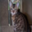

In [4]:
# Get the path to the root directory
ROOT_DIR = os.path.abspath(os.curdir)

# Create the path to the image directories
train_dir = os.path.join(ROOT_DIR, 'datasets/cifar10/train')
test_dir = os.path.join(ROOT_DIR, 'datasets/cifar10/test')

print("Train directory path: ", train_dir)
print("Test directory path: ", test_dir)

# Create a list of training filenames
train_data_dir = pathlib.Path(train_dir)
train_file_paths = list(train_data_dir.glob('*/*')) # Get the list of all training image filepaths
print("\nNumber of training files: ", len(train_file_paths))

# Create a list of test filenames
test_data_dir = pathlib.Path(test_dir)
test_file_paths = list(test_data_dir.glob('*/*')) # Get the list of all test image filepaths
print("Number of test files: ", len(test_file_paths))

print("\nPath of the first training image: ", train_file_paths[0])
PIL.Image.open(train_file_paths[0])

## Create a tf Dataset that Consumes the List of File Names (Filepaths)

There are two options to create the image file list Dataset.

- Option 1: Create the file list Dataset by using the Dataset.from_tensor_slices() method
- Option 2: Create the file list Dataset by using the Dataset.list_files() method

Note that, before using Option 2, if the filenames have already been globbed, then re-globbing every filename with the list_files() method may result in poor performance with remote storage systems.

Since, we have already globbed the file names & paths in the first step, we do not use Option 2.
However, the code for option 2 is provided (commented out).

In [5]:
#_______________________Option 1: "from_tensor_slices" method____________________________


'''
Get filenames (filepaths) as strings in a list (for training & testing images) 
'''
train_fnames=[]
for fname in train_file_paths:
    train_fnames.append(str(fname))

print("Train filenames list length: ", len(train_fnames))

test_fnames=[]
for fname in test_file_paths:
    test_fnames.append(str(fname))

print("Test filenames list length: ", len(test_fnames))


'''
Shuffle the filepaths
'''
random.shuffle(train_fnames)
random.shuffle(test_fnames)


'''
Create the filepath list Dataset (for training & testing images) 
'''
train_dataset = tf.data.Dataset.from_tensor_slices(train_fnames)
test_dataset = tf.data.Dataset.from_tensor_slices(test_fnames)



#_______________________Option 2: "list_flies" method (NOT USED)__________________________

# #Get a training dataset of all files (list of all image paths) matching the glob pattern
# train_dataset = tf.data.Dataset.list_files(str(train_data_dir/'*/*'))
# 
# #Get a test dataset of all files (list of all image paths) matching the glob pattern
# test_dataset = tf.data.Dataset.list_files(str(test_data_dir/'*/*'))


train_dataset_size = train_dataset.cardinality().numpy()
test_dataset_size = test_dataset.cardinality().numpy()


print("\nNumber of samples (image files) in training dataset: ", train_dataset_size)
print("Number of samples (image files) in test dataset: ", test_dataset_size)

Train filenames list length:  50000
Test filenames list length:  10000

Number of samples (image files) in training dataset:  50000
Number of samples (image files) in test dataset:  10000


## Display Some Filepaths from the Dataset

We display the file names (filepaths) of five files from the Dataset. Observe that
- The file names are shuffled
- The letter "b" appears before the filepaths because TensorFlow parses the strings as byte-strings

In [6]:
for f in train_dataset.take(5):
    print(f.numpy())

b'/Users/hasan/datasets/cifar10/train/ship/2878.png'
b'/Users/hasan/datasets/cifar10/train/dog/3067.png'
b'/Users/hasan/datasets/cifar10/train/bird/0458.png'
b'/Users/hasan/datasets/cifar10/train/cat/1455.png'
b'/Users/hasan/datasets/cifar10/train/cat/1348.png'


## Function for Loading the (image, label) Pair from the Filepath


We define the "load_labeled_data" function that takes a filepath and returns the image-label pair. The image is loaded as a float32 Tensor (scaled) and the label is loaded as one-hot encoded int32 Tensor. This function is used by the Dataset to load image-label pairs from the list of filepaths.

The "load_labeled_data" function is defined based on a few other functions below.

In [7]:
'''
Get class names as a list
The class names will be used by the "get_label" function
NOTE: it only works if the data is structured in nested sub-directories named after the classes.
'''
CLASS_NAMES = os.listdir(train_data_dir)
print("\nClass names:\n", CLASS_NAMES)


'''
Function to get the label of an image (file) from its path and class names
The labels are one-hot encoded
'''
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory (i.e., name of the class)
  return tf.cast(parts[-2] == CLASS_NAMES, dtype=tf.int32)
  

'''
This function reads a PNG-encoded image into a uint8 tensor
- Converts the uint8 tensor into float32
- Scales the tensor into the range [0,1] automatically while converting to float32
  Thus, we don't need to scale the images separately
- Resizes the image
Note: if the image encoding is other than PNG, then a suitable decode method should be used.
'''   
def process_image(image, image_height=32, image_width=32):  
    # Decode a PNG-encoded image to a uint8 tensor
    image = tf.image.decode_png(image, channels=3)

    # Convert the unit8 tensor to floats in the [0,1] range
    # Images that are represented using floating point values are expected to have values in the range [0,1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    # Resize image
    image = tf.image.resize(image, [image_height, image_width])
    
    return image
    
'''
This functions returns a one-hot encoded labeled float32 tensor of an image 
based on its file path
'''
def load_labeled_data(file_path):
    img = tf.io.read_file(file_path)
    img = process_image(img)
    label = get_label(file_path)
    return img, label 


Class names:
 ['cat', 'dog', 'truck', 'bird', 'airplane', 'ship', 'frog', 'horse', 'deer', 'automobile']


## Function to Prepare the Dataset for Training

To prepare the Dataset for training, we need to:
- Get the (image, label) pairs from the list Dataset object (that contains list of file paths)
- Load these pairs in memory
- Create mini-batches for training and validation

The Dataset object provides convenient methods for these and additional useful data preprocessing tasks. We chain the relevant methods on the Dataset object to:
- Load (image, label) pairs into the Dataset object
- Cache Dataset
- Shuffle Dataset
- Create mini-batches
- Perform data augmentation
- Prefetch a mini-batch

First, we call the Dataset's map() method that applies the data loading function "load_labeled_data" on each sample of the dataset. The returned new object will emit transformed images and their one-hot encoded labels in the original order.

Second, we cache the data locally. The "cache" method stores dataset elements in memory (by default) or in file for future reusing.
- The first time the dataset is iterated over (i.e., first epoch), its elements will be cached either in the specified file or in memory. 
- Subsequent iterations (i.e., epochs) will use the cached data. This will save some operations (e.g., file opening, data reading, parsing, transforming, etc.) from being executed during each epoch.

Caching should be used judiciously.
- Smaller dataset (that fits into memory): use the cache method. 
- Large dataset:  typically is sharded (split in multiple files), and do not fit in memory. Thus, it should not be cached in memory.

The cache method will produce exactly the same elements during each iteration (epoch) through the dataset. 
For randomizing the iteration order, we need to call the shuffle method after calling cache.

Third, we randomly shuffle the dataset using the shuffle method. The shuffle method randomly shuffles the elements of the dataset. First, it fills a buffer with the dataset with buffer_size elements. Then, it randomly samples elements from this buffer, replacing the selected elements with new elements. For perfect shuffling, the buffer_size should be greater than or equal to the size of the dataset.  However, for large datasets, this isn't possible. So, we will use a large enough buffer_size.

Fourth, we batch the dataset. In the batch method, we set "drop_remainder" to True so that the size of the training set is divisible by the batch_size. It is done by removing enough training examples. 

Finally, we prefetch a batch to decouple the time when data is produced from the time when data is consumed. The transformation uses a background thread and an internal buffer to prefetch elements from the input dataset ahead of the time they are requested. The number of elements to prefetch should be equal to (or possibly greater than)  the number of batches consumed by a single training step. Instead of manually tuning this value, we set it to tf.data.AUTOTUNE, which will prompt the tf.data runtime to tune the value dynamically at runtime.

In [8]:
def prepare_dataset(ds, mini_batch, epochs, shuffle=False, buffer_size=0, augment=False, augment_func=None):

    '''
    The map method applies the argument function (i.e., load_labeled_data) 
    to each element of the dataset, 
    and returns a new dataset containing the transformed elements (i.e., image-label pairs), 
    in the same order as they appeared in the input.
    '''
    ds = ds.map(load_labeled_data, num_parallel_calls=tf.data.AUTOTUNE)
    
    '''
    Cache the dataset elements in memory
    '''
    ds = ds.cache()
  
    '''
    Shuffle the dataset
    '''
    if shuffle:
        ds = ds.shuffle(buffer_size)
      
    '''
    Repeat the shuffled dataset
    '''  
    ds = ds.repeat(count=epochs)
    

    '''
    Batch all datasets
    '''
    ds = ds.batch(mini_batch, drop_remainder=True)

    '''
    Use data augmentation only on the training set
    When training is done using GPUs in a distributed setting, 
    for efficiency, perform data augmentation inside the model. 
    '''
    if augment:
        ds = ds.map(lambda x, y: (augment_func(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    
    '''
    Repeats the batch so each original value is seen "count" times
    Increasing "count" will increase the number of steps per epoch
    '''
    #ds = ds.repeat(count=2) 
    
    '''
    Use buffered prefecting on all datasets
    '''
    return ds.prefetch(buffer_size=tf.data.AUTOTUNE)

## Prepare Dataset for Training

In [9]:
'''
Determine the size of mini-batch for training
It should be a multiple of BATCH_SIZE_PER_REPLICA 
The multiplication factor is determined by the number of available GPUs (or strategy.num_replicas_in_sync)
'''
                                    
BATCH_SIZE_PER_REPLICA = 64

if(num_of_gpu > 0):
    size_of_mini_batch = BATCH_SIZE_PER_REPLICA*num_of_gpu
else:
    size_of_mini_batch = BATCH_SIZE_PER_REPLICA # Uses the CPU, as no GPU is available


'''
Size of test mini-batch 
'''
size_of_mini_batch_test = size_of_mini_batch

print("\nSize of training mini-batch: ", size_of_mini_batch)
print("Size of test mini-batch: ", size_of_mini_batch_test)


'''
Used by the "shuffle" method. 
For small dataset, it should be equal or larger than training set.
'''
buffer_size =   train_dataset_size
print("\nBuffer Size: ", buffer_size)


'''
Set the number of training epochs.
This is required by the repeat method.
'''
no_of_epochs = 5
print("\nEpochs: ", no_of_epochs)


'''
Perform data preprocessing by the CPU.
It is efficient as it ensures that the GPUs will be used only for model training.
'''
with tf.device('/cpu:0'):
    train_loader = prepare_dataset(train_dataset, size_of_mini_batch, no_of_epochs, 
                                   shuffle=True, buffer_size=buffer_size, augment=False, augment_func=None)
    test_loader = prepare_dataset(test_dataset, size_of_mini_batch_test, no_of_epochs)
    no_of_steps_per_epoch = train_dataset_size//size_of_mini_batch
    total_no_of_steps = train_loader.cardinality().numpy()
    print("Data available to run for %d epochs" % (total_no_of_steps//no_of_steps_per_epoch))
    print("Unlimited data available: ", (train_loader.cardinality() == tf.data.INFINITE_CARDINALITY).numpy())


Size of training mini-batch:  64
Size of test mini-batch:  64

Buffer Size:  50000

Epochs:  5
Data available to run for 5 epochs
Unlimited data available:  False


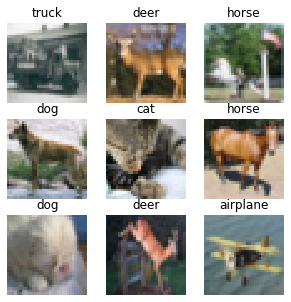

In [10]:
'''
Display some training images from a training Dataset batch
'''
image_batch, label_batch = next(iter(train_loader))

plt.figure(figsize=(5, 5))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i])
    label = label_batch[i]
    plt.title(CLASS_NAMES[tf.argmax(label)])
    plt.axis("off")

## Data Augmentation Layer

We define a Data Augmentation layer by using Keras Image Preprocessing Layer API.

When training is done by a single device (CPU or GPU), data augmentation should be done during preprocessing. However, in distributed training (using multiple GPUs), we can expedite the training time by integrating data augmentation into the learning model so that it is done by GPUs.

In this demo, we perform data augmentation inside the model. For this, we ceate a data augmentation layer by defining a function named "data_augmentation_layer". The function is based on a data augmentation Sequential layer object of class "DataAugmentation". This custom layer object is included in the learning model.

If we need the custom layer to be serializable as part of a learning model, we should implement a get_config() method.

To learn more about data augmentation, see:
https://github.com/rhasanbd/Data-Augmentation-for-Deep-Learning

In [11]:
'''
Define the DataAugmentation class using the tf.Keras' Sequential API.
It creates a data augmentation layer for performing following augmentation to input data:
- Resize (increase the size)
- Random zoom
- Random rotation
- Random horizontal flip
- Random crop (restore the original size)
'''

class DataAugmentation(tf.keras.layers.Layer):
    def __init__(self, original_size, increased_size, rotation_angle_degree, zoom_height_factor, **kwargs):
        super().__init__(**kwargs)
        self.augmentation_layers = [] 
        self.augmentation_layers.append(tf.keras.layers.experimental.preprocessing.Resizing(increased_size, increased_size))
        self.augmentation_layers.append(tf.keras.layers.experimental.preprocessing.RandomZoom(zoom_height_factor, width_factor=None, 
                                                                                              fill_mode='nearest', interpolation='bilinear'))
        self.augmentation_layers.append(tf.keras.layers.experimental.preprocessing.RandomRotation(rotation_angle_degree/360, 
                                                                                                  fill_mode='nearest', interpolation='bilinear'))
        self.augmentation_layers.append(tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"))
        self.augmentation_layers.append(tf.keras.layers.experimental.preprocessing.RandomCrop(original_size, original_size))
        
      
    def call(self, inputs):
        Z = inputs
        for layer in self.augmentation_layers:
            Z = layer(Z)
        return Z
    
    # Required for the custom object's serialization
    def get_config(self):
        config = super().get_config().copy()
        config.update({"augmentation": self.augmentation_layers})
        return config
  

'''
This function creates a sequential tf.Keras layer for performing data augmentation
'''
def data_augmentation_layer(original_size, increased_size, rotation_angle_degree, zoom_height_factor):
    
    d_augmentation = tf.keras.models.Sequential(name='Data-Augmentation')
    d_augmentation.add(DataAugmentation(original_size, increased_size, rotation_angle_degree, zoom_height_factor))

    return d_augmentation  

## Function for Creating the Training Model

We define a function to create the VGG model. First, we define a custom VGG_Block class, which is used to create a VGGNet by the "create_vgg_net" function. The function also uses the custom data augmentation layer.

For more information on the VGGNet, see:
https://github.com/rhasanbd/Convolutional-Neural-Networks/blob/main/CNN-9-Notable%20Architectures-I.ipynb

## VGG Block Class

For serializability of this custom class, we override its get_config() method.

In [12]:
'''
Define the VGG block class using Keras Sequential API 
The VGG_Block class takes two arguments:
- conv_block_number: number of convolutional layers 
- num_of_channels: number of output channels 
'''
class VGG_Block(tf.keras.layers.Layer):
    def __init__(self, conv_block_number, num_of_channels, weight_decay, **kwargs):
        super().__init__(**kwargs)
        self.conv_layers = [] 
        for _ in range(conv_block_number):
            self.conv_layers.append(tf.keras.layers.Conv2D(filters=num_of_channels, kernel_size=(3, 3), strides=1,
                                padding='same', kernel_regularizer=tf.keras.regularizers.l2(weight_decay), use_bias=False))
            self.conv_layers.append(tf.keras.layers.BatchNormalization())
            self.conv_layers.append(tf.keras.layers.Activation("relu"))
        
        self.pool_layer = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid')

    def call(self, inputs):
        Z = inputs
        for layer in self.conv_layers:
            Z = layer(Z)
            
        Z = self.pool_layer(Z)
        return Z
        
    # Required for the custom object's serialization
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            "conv_layers": self.conv_layers,
            "pool_layer": self.pool_layer,
        })
        return config

## Function for Creating a VGGNet

In [13]:
def create_vgg_net(conv_blocks, width, height, channels, num_classes, weight_decay, augmentation=False, **kwargs):
    
    vgg_net = tf.keras.models.Sequential(name='VGG')
    
    vgg_net.add(tf.keras.layers.InputLayer(input_shape=(width, height, channels)))
    
    # Data augmentation layer
    if(augmentation):
        vgg_net.add(data_augmentation_layer(**kwargs))
    
    # Convolutional layers based on the VGG_Block object
    for (conv_block_number, num_of_channels) in conv_blocks:
            vgg_net.add(VGG_Block(conv_block_number, num_of_channels, weight_decay))
    
    # Flatten the convnet output to feed it with fully-connected layers
    vgg_net.add(tf.keras.layers.Flatten())
    
    # Fully-connected layers
    vgg_net.add(tf.keras.layers.Dense(units=64, activation='relu'))
    vgg_net.add(tf.keras.layers.Dropout(0.5))
    vgg_net.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))
    
    return vgg_net

## Create Model

In [14]:
'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
tf.keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Define the optimizer
'''
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-1, momentum=0.9, nesterov=False)


'''
We use the layer_info variable for creating the VGG model.
It contains a list of tuples (one per block).
Each tuple contains two values: 
- number of convolutional layers
- the number of output channels
These two arguments are used to call the VGG_Block function
'''
layer_info = ((2, 32), (2, 64)) 



'''
Open a strategy scope to create and compile the model
Everything that creates variables should be under the strategy scope
'''
with strategy.scope():
    
    '''
    If the "augment" is set to True, then pass the following keyword arguments.
    - original_size
    - increased_size
    - rotation_angle_degree
    - zoom_height_factor
    '''
    model = create_vgg_net(layer_info, 32, 32, channels=3, num_classes=10,
                           weight_decay=0.001,
                           augment=True, 
                           original_size=32, 
                           increased_size=36, 
                           rotation_angle_degree=20, 
                           zoom_height_factor=0.6)
    model.summary()
    loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(loss=loss_object,
              optimizer=optimizer,
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

Model: "VGG"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg__block (VGG_Block)       (None, 16, 16, 32)        10336     
_________________________________________________________________
vgg__block_1 (VGG_Block)     (None, 8, 8, 64)          55808     
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                262208    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 329,002
Trainable params: 328,618
Non-trainable params: 384
_______________________________________________________

## Model Training

In [15]:
'''
The model name variable is used for model serialization
'''
model_name = "CIFAR10_VGG"

'''
Create model checkpoint "callback" object to save only the best performing models
'''
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(model_name, save_best_only=True)


'''
Create a TensorBoard "callback" object for the learning schedule
'''
lschedule_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.1,
                              patience=10, min_lr=0.000001, mode='auto', verbose=1)


'''
Train the model
'''
print("\nTraining started ...")

history = model.fit(train_loader, 
                    epochs=no_of_epochs,
                    steps_per_epoch=train_dataset_size // size_of_mini_batch,
                    validation_steps=test_dataset_size // size_of_mini_batch_test,
                    verbose=1,
                    validation_data=test_loader,
                    callbacks=[lschedule_cb])


'''
Save the model

Save the entire model to disk in the TensorFlow SavedModel format by using the model.save() method. 
It is the default format with model.save().
Another option is the older Keras H5 format (not used here). 

SavedModel is a comprehensive save format that saves: 
- the model architecture 
- weights
- the traced Tensorflow subgraphs of the call functions 

This enables Keras to restore both built-in layers as well as custom objects (e.g., data augmentation layer).


Calling model.save(model_name) creates a folder named model_name. 
It contains the following directories and file (.pb):
- assets  
- saved_model.pb  
- variables

The saved_model.pb file stores the actual TensorFlow program, or model. 
It includes the model architecture, and training configuration (e.g., optimizer, losses, and metrics) 

The variables directory contains weights (i.e., a standard training checkpoint).

The assets directory contains files used by the TensorFlow graph.
For example text files used to initialize vocabulary tables.

For more informattion, see:
https://keras.io/guides/serialization_and_saving/
'''

# Path to the Saved_Models diretory in which the model will be serialized
saved_model_directory = os.path.join(ROOT_DIR, 'Saved_Models')
saved_model_path = os.path.join(saved_model_directory, model_name)

model.save(saved_model_path)


Training started ...
Epoch 1/5


/Users/hasan/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


781/781 [==============================] - 112s 139ms/step - loss: 2.5084 - categorical_accuracy: 0.0987 - val_loss: 2.3282 - val_categorical_accuracy: 0.1001
Epoch 2/5
781/781 [==============================] - 104s 133ms/step - loss: 2.3135 - categorical_accuracy: 0.0971 - val_loss: 2.3058 - val_categorical_accuracy: 0.1002
Epoch 3/5
781/781 [==============================] - 108s 138ms/step - loss: 2.3070 - categorical_accuracy: 0.0989 - val_loss: 2.3091 - val_categorical_accuracy: 0.1001
Epoch 4/5
781/781 [==============================] - 109s 139ms/step - loss: 2.2983 - categorical_accuracy: 0.1040 - val_loss: 2.1984 - val_categorical_accuracy: 0.1527
Epoch 5/5
781/781 [==============================] - 113s 145ms/step - loss: 2.1340 - categorical_accuracy: 0.1803 - val_loss: 2.0962 - val_categorical_accuracy: 0.2165


INFO:tensorflow:Assets written to: /Users/hasan/Saved_Models/CIFAR10_VGG/assets


INFO:tensorflow:Assets written to: /Users/hasan/Saved_Models/CIFAR10_VGG/assets


# Model Evaluation

We evaluate the trained model using various techniques.

- Evaluate the Model using the History Object
- Evaluate the Model using its predict() Method on the Batched Test Dataset Object
- Evaluate the Model using its predict() Method on the Full Test Set
- Evaluation using the Saved Model



## Evaluate the Model using the History Object

The model's fit method returns a History object, which we use for getting information on the model's performance. 

The History object has an attribute named "history" that contains a record of training loss values and metrics values at successive epochs, as well as validation loss values and validation metrics values (if applicable).

In [16]:
numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)

train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']


train_loss = history.history['loss']
val_loss = history.history['val_loss']


# Read the last value from the list that represents final epoch statistics
print("\n{} Train Accuracy: {:.3f}".format(model_name, train_acc[-1]))
print("{} Train Loss: {:.3f}".format(model_name, train_loss[-1]))

print("\n{} Validation Accuracy: {:.3f}".format(model_name, val_acc[-1]))
print("{} Validation Loss: {:.3f}".format(model_name, val_loss[-1]))

Epochs:  5

CIFAR10_VGG Train Accuracy: 0.180
CIFAR10_VGG Train Loss: 2.134

CIFAR10_VGG Validation Accuracy: 0.217
CIFAR10_VGG Validation Loss: 2.096


## Evaluate the Model using its predict() Method on the Batched Test Dataset Object

In [17]:
test_loss, test_accuracy = model.evaluate(test_loader.take(-1), verbose=0)
print("\nTest Accuracy: {:.3f}".format(test_accuracy))
print("Test Loss: {:.3f}".format(test_loss))


Test Accuracy: 0.217
Test Loss: 2.096


## Evaluate the Model using its predict() Method on the Full Test Set

For evaluating the model using the test set, we need to create: 
- an array of test images (as Tensors)
- an array of integer labels 

Then, we predict integer lables using the test images and compute model's performance using the true integer labels. Following evaluation metrics are used:
- Accuracy
- Confusion matrix
- Classification report



## Create Arrays of Test Images and Labels

From the test Dataset object we create an array of tensor images and an array of their labels. The loaded labels are one-hot encoded, which we convert as an array of integer labels. 

In [18]:
# Load the test dataset as image-label (one-hot encoded) pairs
ds_test = test_dataset.map(load_labeled_data, num_parallel_calls=tf.data.AUTOTUNE)

# Create lists of test images and their labels (one-hot encoded) 
images_test_list = []
labels_test_list = []
count = 0
for images, labels in ds_test.take(-1):
    count += 1
    images_test_list.append(images)
    labels_test_list.append(labels)

print("Number of Test Images: ", count)


# Convert the lists of images and labels (one-hot encoded) as arrays
#images_test = np.asarray(images_test_list)
#labels_test_one_hot_encoded = np.asarray(labels_test_list)
images_test = tf.convert_to_tensor(images_test_list)
labels_test_one_hot_encoded = tf.convert_to_tensor(labels_test_list)

print("\nTest Images Array Shape: ", images_test.shape)
print("Test Images Array Data Type: ", images_test.dtype)


print("\nTest Labels Array Shape (one-hot encoded): ", labels_test_one_hot_encoded.shape)
print("Test Labels Array Data Type (one-hot encoded): ", labels_test_one_hot_encoded.dtype)

# Create a list of integer labels by converting one-hot encoded labels 
labels_test_list = []
for i in range(labels_test_one_hot_encoded.shape[0]):
    labels_test_list.append(tf.argmax(labels_test_one_hot_encoded[i]))

# Number of integer labels 
print("\nLength of the integer labels list: ", len(labels_test_list))

# Convert the integer labels list as a numpy array
#labels_test = np.asarray(labels_test_list)
labels_test = tf.convert_to_tensor(labels_test_list)
print("\nShape of the integer label array: ", labels_test.shape)
print("Data type of the integer label array: ", labels_test.dtype)

print("\nSample one-hot encoded label: ", labels_test_one_hot_encoded[670])
print("Sample integer label: ", labels_test[670])

Number of Test Images:  10000

Test Images Array Shape:  (10000, 32, 32, 3)
Test Images Array Data Type:  <dtype: 'float32'>

Test Labels Array Shape (one-hot encoded):  (10000, 10)
Test Labels Array Data Type (one-hot encoded):  <dtype: 'int32'>

Length of the integer labels list:  10000

Shape of the integer label array:  (10000,)
Data type of the integer label array:  <dtype: 'int64'>

Sample one-hot encoded label:  tf.Tensor([0 0 0 0 0 0 1 0 0 0], shape=(10,), dtype=int32)
Sample integer label:  tf.Tensor(6, shape=(), dtype=int64)


## Make Predictions using the Test Images Tensor

In [19]:
# Predict one-hot encoded labels for the test images
labels_test_predicted_one_hot_encoded = model.predict(images_test)
print("\nShape of the one-hot encoded predictions array: ", labels_test_predicted_one_hot_encoded.shape)
print("Data type of the one-hot encoded predictions array: ", labels_test_predicted_one_hot_encoded.dtype)

# Create an array of integer labels by converting one-hot encoded labels array 
# This is done by getting the label/index of the highest probability class
labels_test_predicted = tf.argmax(labels_test_predicted_one_hot_encoded, axis=1) 
print("\nShape of the integer predictions array: ", labels_test_predicted.shape)
print("Data type of the integer predictions array: ", labels_test_predicted.dtype)

print("\nSample one-hot encoded predicted label: ", labels_test_predicted_one_hot_encoded[670])
print("Sample integer true label: ", labels_test_predicted[670])

test_accuracy = np.mean(labels_test_predicted == labels_test)
print("\nTest Accuracy: ", test_accuracy)

print("\nTest Confusion Matrix:")
print(confusion_matrix(labels_test, labels_test_predicted))

print("\nClassification Report:")
print(classification_report(labels_test, labels_test_predicted))


Shape of the one-hot encoded predictions array:  (10000, 10)
Data type of the one-hot encoded predictions array:  float32

Shape of the integer predictions array:  (10000,)
Data type of the integer predictions array:  <dtype: 'int64'>

Sample one-hot encoded predicted label:  [0.16312894 0.14544518 0.06731509 0.1218327  0.0626487  0.03945874
 0.13469273 0.10271773 0.10691939 0.05584068]
Sample integer true label:  tf.Tensor(0, shape=(), dtype=int64)

Test Accuracy:  0.2166

Test Confusion Matrix:
[[881   0  37   2   3   0   0  77   0   0]
 [846   0  13   4   4   0   0 133   0   0]
 [356   0 630   0   9   0   0   5   0   0]
 [781   0  35  10  47   0   0 127   0   0]
 [463   0 200  37 273   0   0  27   0   0]
 [381   0 407  31 180   0   0   1   0   0]
 [871   0  24   2   1   0   0 102   0   0]
 [582   0  27   9   9   0   0 372   1   0]
 [724   0  20   4  21   0   0 231   0   0]
 [310   0 677   0   8   0   0   5   0   0]]

Classification Report:
              precision    recall  f1-scor

/Users/hasan/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Evaluation using the Saved Model

We evaluate the saved model using its predict() method on the full test dataset.

The saved model can be loaded by using tf.keras.models.load_model() method. If the model contains custom layers, then we need to set the "custom_objects" argument. It should be a dictionary mapping names (strings) to custom classes or functions to be considered during deserialization.

In this demo, the training model is a custom object. Because it is created using the "vgg" function that is based on the custom data augmentation layer and the VGG_Block custom layer.

In [20]:
# Load the saved model (containing custom objec) using with the custom_object argument
saved_model = tf.keras.models.load_model(saved_model_path, custom_objects={"create_vgg_net": create_vgg_net})


# Predict one-hot encoded labels for the test images
labels_test_predicted_one_hot_encoded = saved_model.predict(images_test)
print("\nShape of the one-hot encoded predictions array: ", labels_test_predicted_one_hot_encoded.shape)
print("Data type of the one-hot encoded predictions array: ", labels_test_predicted_one_hot_encoded.dtype)

# Create an array of integer labels by converting one-hot encoded labels array 
# This is done by getting the label/index of the highest probability class
labels_test_predicted = tf.argmax(labels_test_predicted_one_hot_encoded, axis=1) 
print("\nShape of the integer predictions array: ", labels_test_predicted.shape)
print("Data type of the integer predictions array: ", labels_test_predicted.dtype)

print("\nSample one-hot encoded predicted label: ", labels_test_predicted_one_hot_encoded[670])
print("Sample integer true label: ", labels_test_predicted[670])

test_accuracy = np.mean(labels_test_predicted == labels_test)
print("\nTest Accuracy: ", test_accuracy)

print("\nTest Confusion Matrix:")
print(confusion_matrix(labels_test, labels_test_predicted))

print("\nClassification Report:")
print(classification_report(labels_test, labels_test_predicted))


Shape of the one-hot encoded predictions array:  (10000, 10)
Data type of the one-hot encoded predictions array:  float32

Shape of the integer predictions array:  (10000,)
Data type of the integer predictions array:  <dtype: 'int64'>

Sample one-hot encoded predicted label:  [0.16312894 0.14544518 0.06731509 0.1218327  0.0626487  0.03945874
 0.13469273 0.10271773 0.10691939 0.05584068]
Sample integer true label:  tf.Tensor(0, shape=(), dtype=int64)

Test Accuracy:  0.2166

Test Confusion Matrix:
[[881   0  37   2   3   0   0  77   0   0]
 [846   0  13   4   4   0   0 133   0   0]
 [356   0 630   0   9   0   0   5   0   0]
 [781   0  35  10  47   0   0 127   0   0]
 [463   0 200  37 273   0   0  27   0   0]
 [381   0 407  31 180   0   0   1   0   0]
 [871   0  24   2   1   0   0 102   0   0]
 [582   0  27   9   9   0   0 372   1   0]
 [724   0  20   4  21   0   0 231   0   0]
 [310   0 677   0   8   0   0   5   0   0]]

Classification Report:
              precision    recall  f1-scor